In [12]:
from transmitter import *
from reciever import *
import numpy as np
import simpleaudio as sa
from scipy.io.wavfile import read
from scipy.fft import fft
import matplotlib.pyplot as plt

In [13]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21             # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}

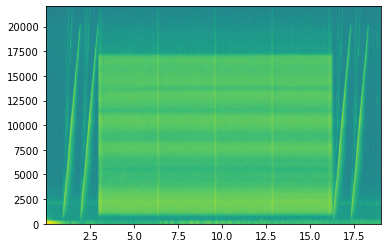

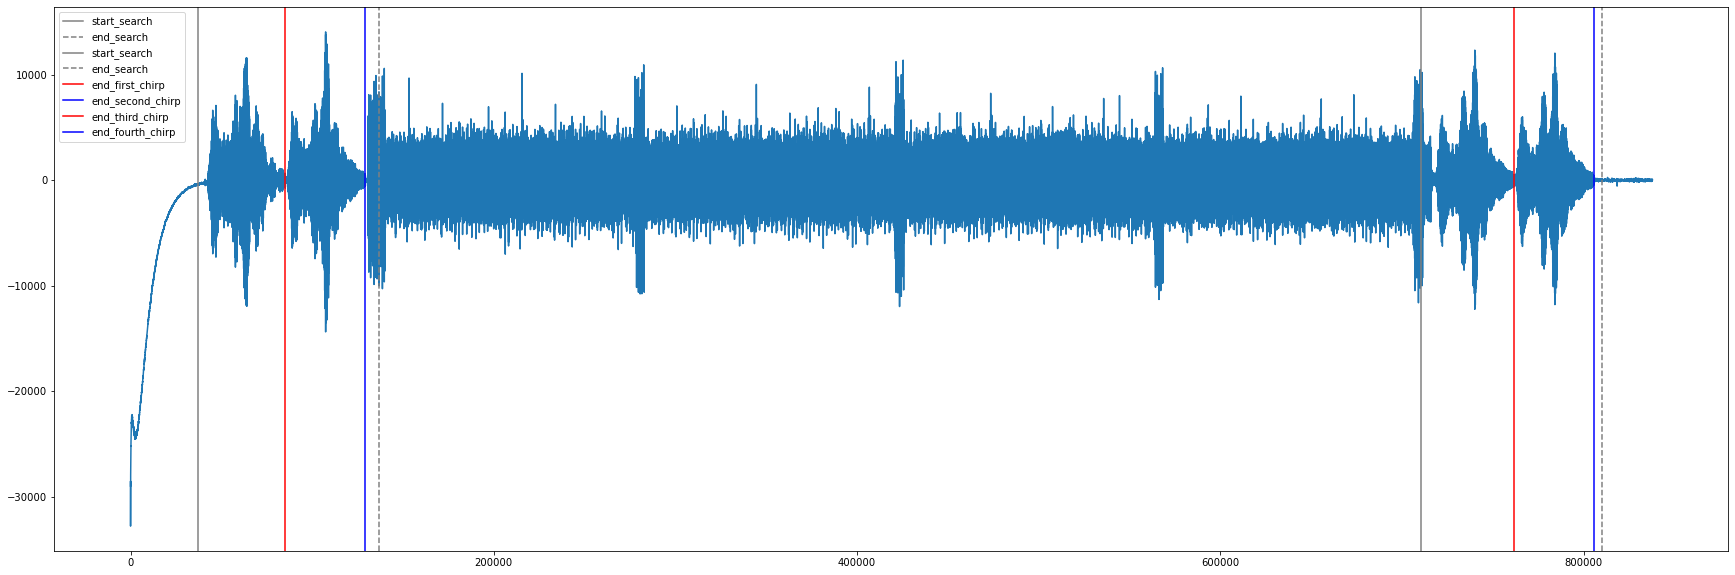

In [39]:
Fs, auds = read('Group_7_rec.wav')

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(auds, Fs=fs)
plt.show()

chirps = chirpEnds(auds, graph_display=True)
delayed_start = chirps[1] + 1500 + 1
delayed_end = chirps[2] - 44100 - 1500 - 1

In [40]:
ayy,bee = channelEstimate(auds[delayed_start:delayed_start+2304*4], ofdm)

data_start  = delayed_start+2304*4
delayed_end_snc = delayed_end - 2304*4
num_symbs_guess = round((delayed_end-data_start)/2304)
new_end = data_start + num_symbs_guess*2304
print("Difference in end, new, snc?:", new_end-delayed_end_snc, new_end, delayed_end_snc)

Difference in end, new, snc?: 9218 716005 706787


(348480,)
347976
(347976,)


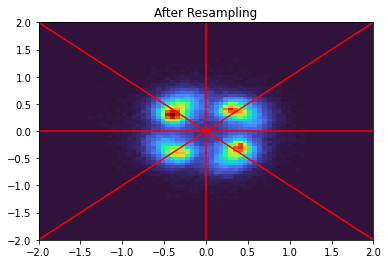

In [44]:
of=1
fo=0
win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('hamming', win_len)
resampled_aud = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start)

decoded, symbols_rec = standard_deconstructor(resampled_aud,ofdm,channel_H=chanest_padd(ayy,ofdm),retSymbs=True,ldpc_encoded=True,add_rotate=0.25j)

plt.hist2d(np.real(symbols_rec.flatten()), np.imag(symbols_rec.flatten()), bins=(500, 500),cmap=plt.cm.turbo)
plt.axvline(x = 0 , color = 'r')
plt.axhline(y = 0 , color = 'r')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.axline((-2,-2), (2,2), color ='r')
plt.axline((2,-2), (-2,2), color ='r')
plt.title('After Resampling')
plt.show()


(619200,)
618192
(618192,)
(619200,)
618192
(618192,)


Text(0.5, 1.0, 'After Resampling - No Window')

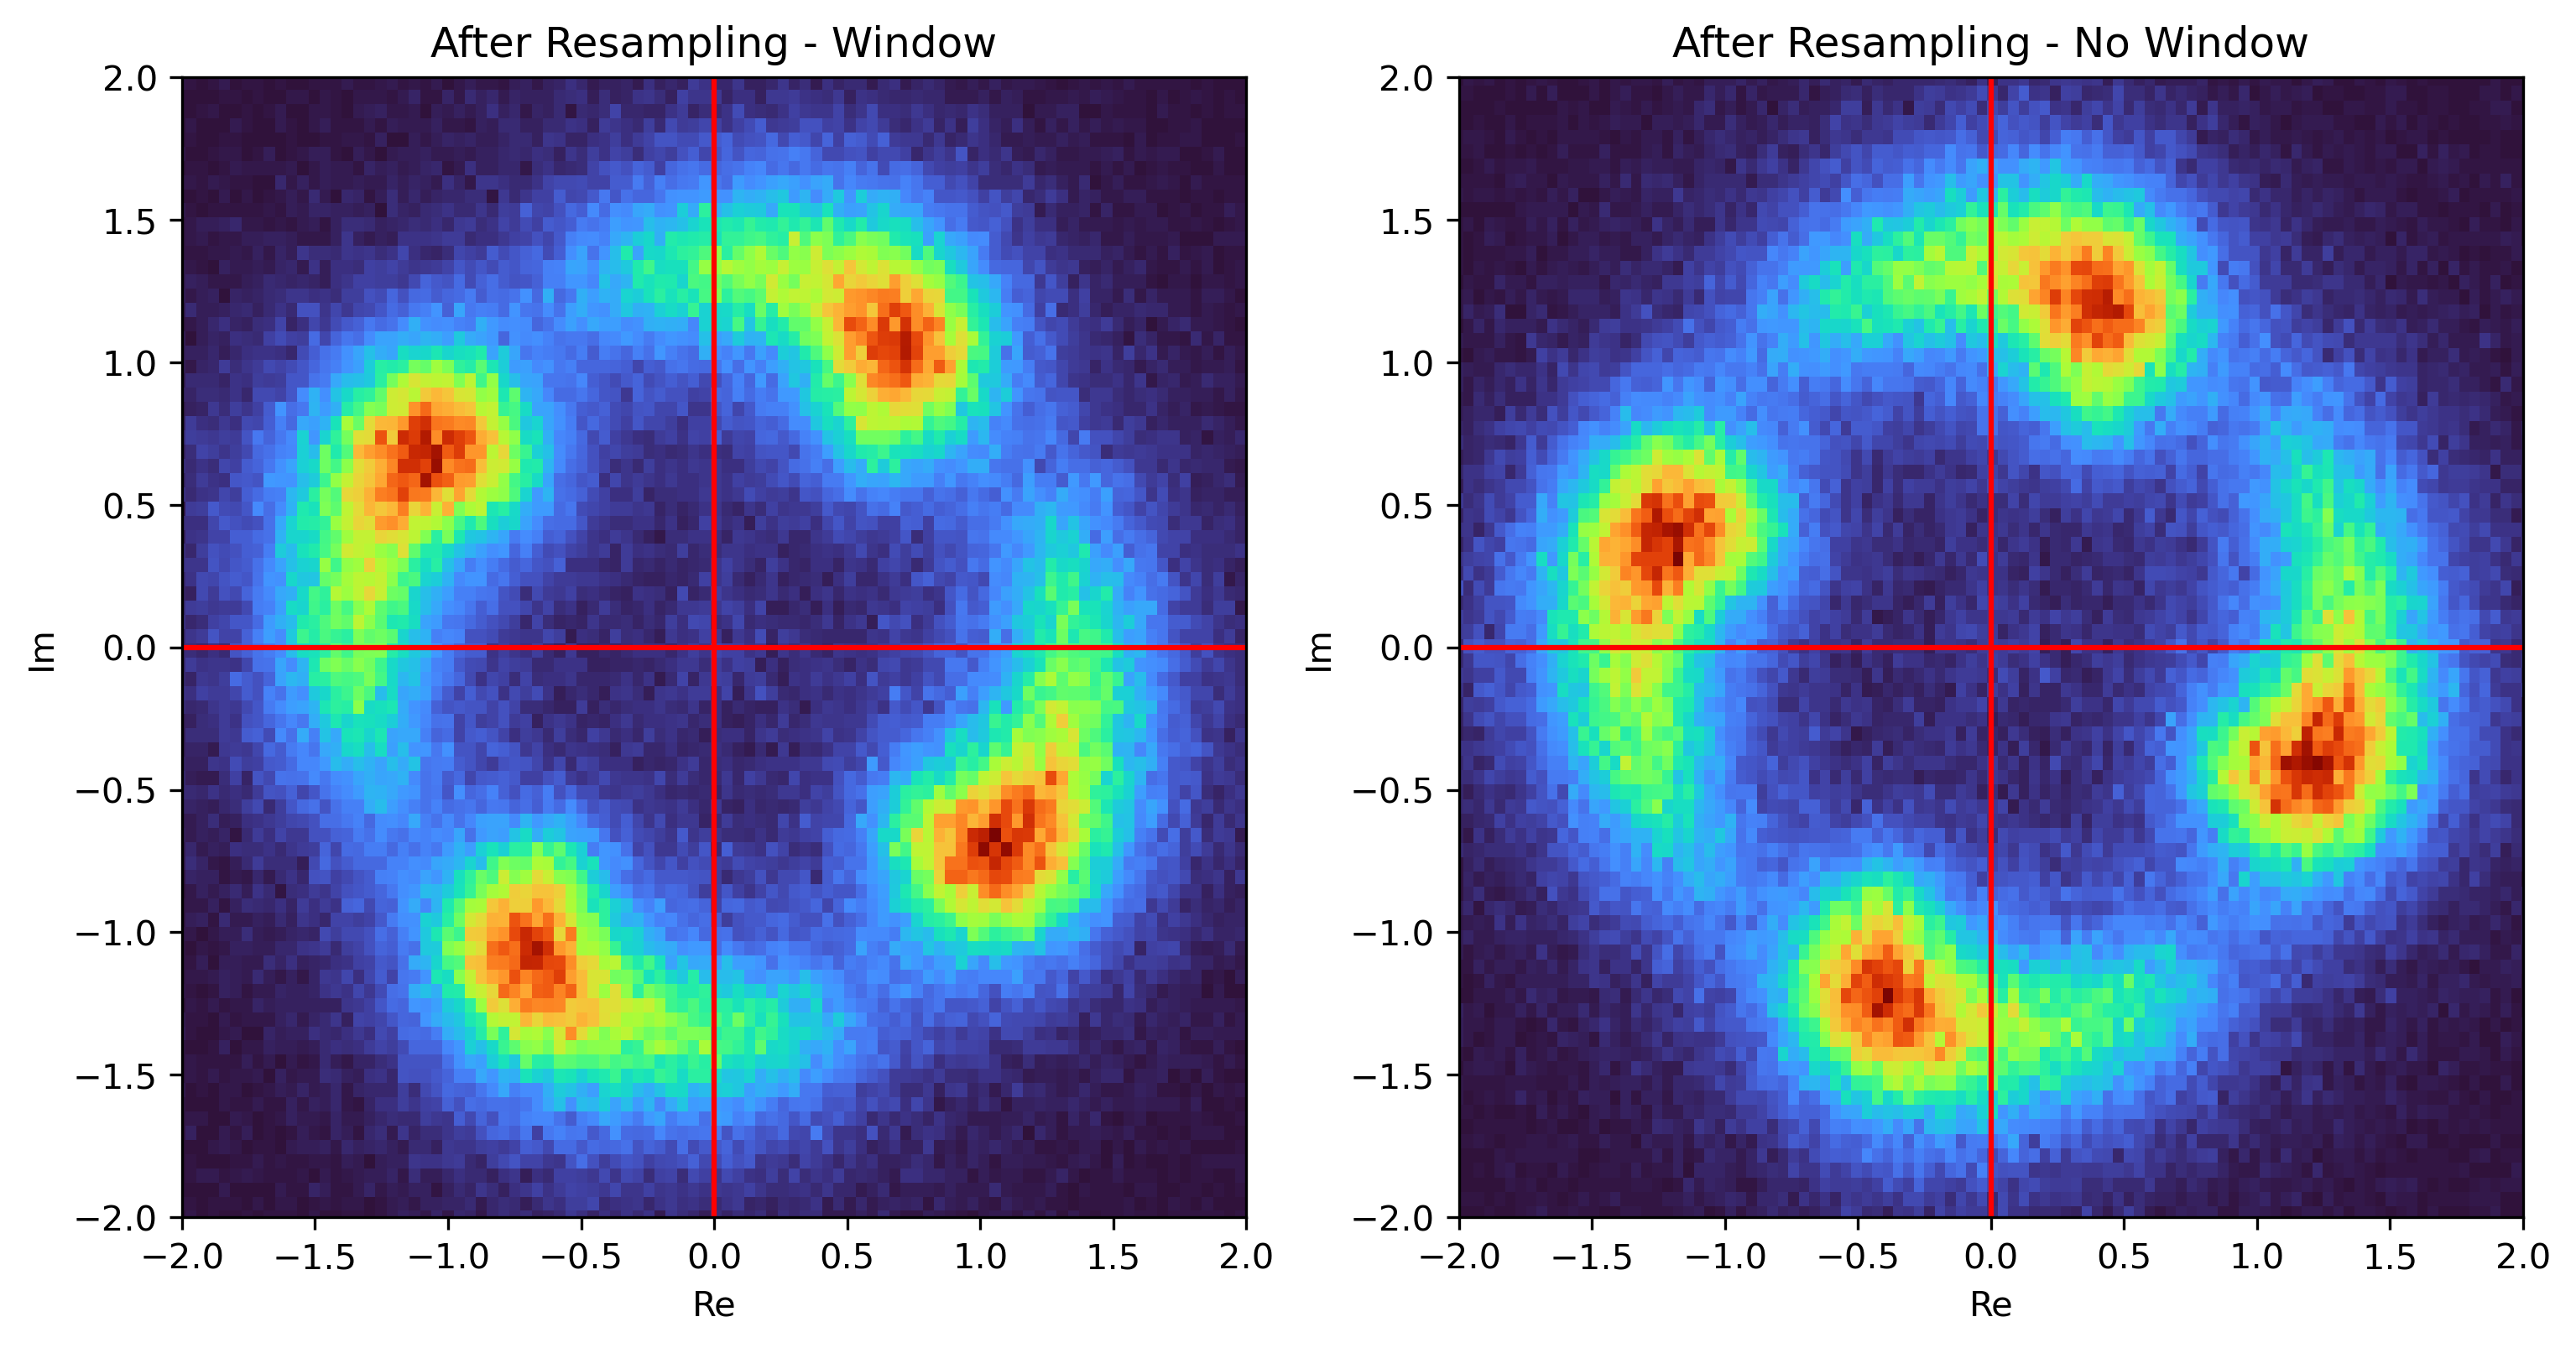

In [17]:
of=5
fo=0
win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('hamming', win_len)
resampled_aud2 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start)
resampled_aud4 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start, window = win)

#decoded, symbols_rec = standard_deconstructor(resampled_aud4, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True)
decoded2, symbols_rec2 = standard_deconstructor(resampled_aud2, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, ldpc_encoded = False)
decoded3, symbols_rec3 = standard_deconstructor(resampled_aud2, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, add_rotate=0.11j, ldpc_encoded = False)

fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 300)

axs[0].hist2d(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
axs[0].axvline(x = 0 , color = 'r')
axs[0].axhline(y = 0 , color = 'r')
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)
axs[0].set_xlabel("Re")
axs[0].set_ylabel("Im")
axs[0].set_title("After Resampling - Window")


axs[1].hist2d(np.real(symbols_rec3.flatten()), np.imag(symbols_rec3.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
axs[1].axvline(x = 0 , color = 'r')
axs[1].axhline(y = 0 , color = 'r')
axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
axs[1].set_xlabel("Re")
axs[1].set_ylabel("Im")
axs[1].set_title("After Resampling - No Window")

In [38]:
file_type, data_len = decode_header(decoded)
print(file_type,data_len)
data = decoded[7*8*3:data_len]
str_data = [str(i) for i in data]
bytes_int = [int(''.join(map(str, str_data[i:i+8])),2) for i in range(0, len(str_data), 8)]
with open("trial2_group_8{}".format(file_type), 'wb') as f:
    f.write(bytearray(bytes_int))

.jpg 305736


In [50]:
data = decoded[:21624*8]
str_data = [str(i) for i in data]
bytes_int = [int(''.join(map(str, str_data[i:i+8])),2) for i in range(0, len(str_data), 8)]


with open("trial1_group_7{}".format('.txt'), 'wb') as f:
    f.write(bytearray(bytes_int))


38217.0